# CMPE538. Project 2.A

In this project, we use CMU Panoptic dataset. We visualize 3D body in 3D space. Human body is represted by 19 joints skeleton in the CMU Panoptic dataset. The dataset contains 3D human body, hand, face annotations in a very complex multiview camera environment. There are many sequences with multiview RGB data together with annotations. In this project, we will only use a small sequence named "171204_pose1_sample".

Please fill your info.

Name/Surname: Emre Girgin


E-mail: emre.girgin@boun.edu.tr

Student No: 2021700060

# 3D Keypoint Visualization in 3D view

In this example, we visualize 3D body/face/hands in 3D space

In [1]:
import numpy as np
import json
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')
# importing required libraries

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# %matplotlib inline
#plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
# Setup paths
data_path = '../'
seq_name = '171204_pose1_sample'
hd_img_path = data_path+seq_name+'/hdImgs/'


## Load camera calibration parameters (for visualizing cameras)

In [3]:
# Load camera calibration parameters (for visualizing cameras)
with open(data_path+seq_name+'/calibration_{0}.json'.format(seq_name)) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.items():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))

    
# Choose only HD cameras 
hd_cam_idx = zip([0] * 30,range(0,30))
hd_cameras = [cameras[cam].copy() for cam in hd_cam_idx]

## Select Image Frame

In [4]:
# Select HD Image index (Remember there are 101 frames in "171204_pose1_sample") 
hd_idx = 42 # frame_id

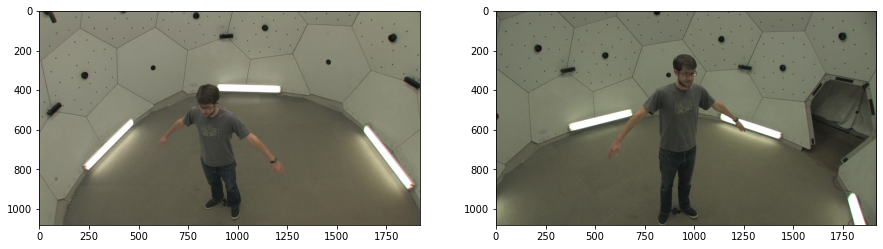

In [5]:
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

# Select an HD camera (0,0) - (0,30), where the zero in the first index means HD camera 
cam17 = cameras[(0,17)] # 
cam21 = cameras[(0,21)] # 

# Load the corresponding HD image
image_path17 = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam17['panel'], cam17['node'], hd_idx)
image_path21 = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam21['panel'], cam21['node'], hd_idx)

rcParams['figure.figsize'] = 15 ,10

im17  = mpimg.imread(image_path17 )
im21 = mpimg.imread(image_path21)

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(im17 )
ax[1].imshow(im21)

## Plot 3D GT skeleton and HD Cameras in Scene
We plot 3D skeleton joints together with locations of HD cameras. We pick the skeleton annotation in frame_id 42.

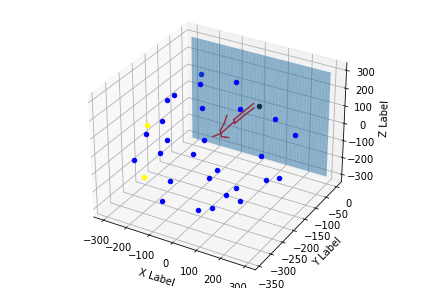

In [19]:
# for creating a responsive plot
%matplotlib widget
  

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
ax.axis('auto')  


# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev = -90, azim=-90)


ax.set_title("3D plot")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('auto')


# 0,0,0 (the center of World coord. system)
ax.scatter(0, 0, 0, '*', color=[0,0,0])

# Add Ground Plane
xx, zz = np.meshgrid(range(-300,300), range(-300,300))
yy = 0*xx
ax.plot_surface(xx, yy, zz, alpha=0.5)



chosen_cameras = ["00_17","00_21"]
for cam in hd_cameras:
    ###################################################################
    # HERE !
    cc = -cam["R"].T @ cam["t"]
    ###################################################################

    if cam['name'] in chosen_cameras:
        ax.scatter(cc[0], cc[1], cc[2], '*', color=[1,1,0]) #Chosen cam's will be Yellow
    else:
        ax.scatter(cc[0], cc[1], cc[2], '*', color=[0,0,1]) # Other HD cams will be Blue
 
       
    
'''
## Visualize 3D Body
'''
# Edges between joints in the body skeleton
# Info: The joint connectivities are not standard. These are special for CMU Panoptic dataset. 
# Number of joints, orders can change from dataset to dataset.
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


# Load frame's skeletons
skel3D = np.load('3D_GT_skels.npy')
skel = skel3D[hd_idx].T

for edge in body_edges:
    ax.plot(skel[0,edge], skel[1,edge], skel[2,edge], color=[1,0,0])


plt.show()

## Transform skeleton
In this part, we apply translate, rotate and scale operations on the ground truth skeleton (frame_id=42).
The CMU skeleton has 19 joints in annotations. Each joint has 3 dim (x,y,z).

In [7]:
# Load frame's skeletons
skel3D = np.load('3D_GT_skels.npy')
skel = skel3D[hd_idx].T #get 3D GT Skel for frame 42 ~ Shape [3,19]

# Transform 3D skeleton joints -> homogenous coord. to make operation with matrix maltiplication.
ones = np.ones((1,19))
homogenous_skel = np.vstack((skel,ones))

####  Translation matrix: move 200 mm along +x, move 150 mm along -z direction.

In [8]:
###################################################################
# HERE !
translation_matrix = np.array([[1, 0, 0, 200],[0, 1, 0, 0],[0, 0, 1, -150],[0, 0, 0, 1]]) # Manually Assign translation_matrix.shape 4x4
###################################################################


In [9]:
# Translate skeleton with matrix multiplication
translated_skel = np.dot(translation_matrix , homogenous_skel)

####  Rotation matrix: Turn around Y axis +90deg.

In [10]:
###################################################################
# HERE !
theta = np.pi/2 # 
rotation_matrix = np.array([
    [np.cos(theta), 0, np.sin(theta), 0],
    [0, 1, 0, 0],
    [-np.sin(theta), 0, np.cos(theta), 0],
    [0, 0, 0, 1]]) # Manually Assign rotation matrix . shape 4x4
###################################################################

In [11]:
# Translate skeleton with matrix multiplication
rotatedY_skel = np.dot(rotation_matrix , homogenous_skel)

####  Rigid Transformation: g(R,t)
##### R -> Rotation matrix: Turn around Y axis +90deg.
##### t   -> Translation matrix: move 200 mm along +x, move 150 mm along -z direction.

In [12]:
###################################################################
# HERE !
rigidTransformation_matrix = np.hstack((rotation_matrix[:, :-1], translation_matrix[:, -1:]))  # Calculate Rigid Trans matrix for given R, t
###################################################################

In [13]:
# Apply Rigid Transformatin to skeleton with matrix multiplication
rigid_skel = np.dot(rigidTransformation_matrix , homogenous_skel)

## Plot 3D GT skeleton together with transformations
We will plot 3D skeleton joints together with locations of HD cameras. We pick the 3D skeleton annotation in frame_id 42.

Visually analyze your skeletons and transformations.

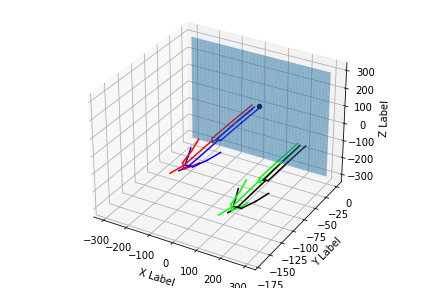

In [14]:
%matplotlib widget
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
ax.axis('auto')  


# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev = -90, azim=-90)


ax.set_title("3D plot")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('auto')


# 0,0,0 (world coord)
ax.scatter(0, 0, 0, '*', color=[0,0,0])

# Add Ground Plane
xx, zz = np.meshgrid(range(-300,300), range(-300,300))
yy = 0*xx
ax.plot_surface(xx, yy, zz, alpha=0.5)



'''
## Visualize 3D Body
'''
# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


# Load frame's skeletons
skel3D = np.load('3D_GT_skels.npy')
skel = skel3D[hd_idx].T

for edge in body_edges:
    #3D GT for frame 42
    ax.plot(skel[0,edge], skel[1,edge], skel[2,edge], color=[1,0,0])
    
    #Transformations of 3D GT for frame 42
    ax.plot(translated_skel[0,edge], translated_skel[1,edge], translated_skel[2,edge], color=[0,1,0])
    ax.plot(rotatedY_skel[0,edge], rotatedY_skel[1,edge], rotatedY_skel[2,edge], color=[0,0,1])
    ax.plot(rigid_skel[0,edge], rigid_skel[1,edge], rigid_skel[2,edge], color=[0,0,0])

plt.show()

## MPJPE (Mean Per Joint Position Error)
Now, we calculate the difference (error) between two skeletons. MPJPE is one of the most popular metric in 3D Human Pose Estimation. The error is calculated by average joint by joint euclidean difference between given two skeletons. The unit of metric is milimeters.

Average of Euclidean distance between ground truth and prediction for all joints.

In [15]:
# Mean Per Joint Position Error
def MPJPE(skel1,skel2):
    
    assert skel1.shape ==skel2.shape
    
    error = 0.0
    ###################################################################
    # HERE !
    #
    for i in range(skel1.shape[1]):
        error += np.linalg.norm(skel1[:,i] - skel2[:, i])
    
    return error / skel1.shape[1] # the mean
    ###################################################################


####  Calculate MPJPE against GT-skeleton (id=42) vs Translated/Rotated/Rigid skeletons

In [16]:
# Hint: Check the last row of translated_skel,rotatedY_skel,rigid_skels. Possibly, They are still in homogenous coord.
# Transform Homog. Coord -> World coord. ==> Remove Row with Zeros
skel3D = np.load('3D_GT_skels.npy')
skel = skel3D[42].T
###################################################################
# HERE !
#
inv_translated_skel = translated_skel - translation_matrix[:, -1:]
inv_rotatedY_skel = np.dot(rotation_matrix.T, rotatedY_skel)
inv_rigid_skel = np.dot(np.linalg.inv(rigidTransformation_matrix), rigid_skel)

e1 = MPJPE(skel, inv_translated_skel[:-1,:]) # I expect you to fill "?".
e2 = MPJPE(skel, inv_rotatedY_skel[:-1,:])
e3 = MPJPE(skel, inv_rigid_skel[:-1,:])
###################################################################

print(f"Between Original Skeleton (id=42) and Translated Skel: MPJPE {e1} mm.")
print(f"Between Original Skeleton (id=42) and RotatedY Skel: MPJPE {e2} mm.")
print(f"Between Original Skeleton (id=42) and Rigid Skel: MPJPE {e3} mm.")

Between Original Skeleton (id=42) and Translated Skel: MPJPE 9.750012697712015e-15 mm.
Between Original Skeleton (id=42) and RotatedY Skel: MPJPE 0.0 mm.
Between Original Skeleton (id=42) and Rigid Skel: MPJPE 1.1833994370852284e-14 mm.


####  Calculate MPJPE  against all frames ( 42 vs 0,..,100 )

In [17]:
# Read  3D skeleton annotations for all frames in the seq.
mpjpeDict = {}
referenceSkel = skel3D[42]

for frame_id in range(101):
    
    mpjpeDict[frame_id] = MPJPE(referenceSkel,skel3D[frame_id])


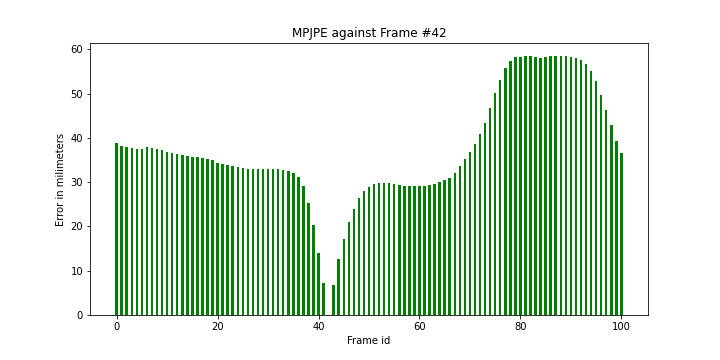

In [18]:
import matplotlib.pyplot as plt

frameList = list(mpjpeDict.keys())
mpjpeValues= list(mpjpeDict.values())


fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(frameList,mpjpeValues, color ='green',
        width = 0.5)

plt.xlabel("Frame id")
plt.ylabel("Error in milimeters")
plt.title("MPJPE against Frame #42")
plt.show()

# Visually Check consecutive frames of 42 have less MPJPE error in bar plot!

### References
1 -https://github.com/cbsudux/Human-Pose-Estimation-101#mean-per-joint-position-error---mpjpe

2 -https://ksimek.github.io/2012/08/22/extrinsic/

3 -
